# 汽车边缘识别
    1.随机取汽车图片上的一小块patch,凡是取到了一个像素的汽车,就作为正例数据集,car
    2.随机取汽车图片上的一小块patch,凡是取到了非汽车区域,就作为负例数据集,noncar
    3.标注数据不仅仅是0和1,还需要训练汽车的边缘特征

In [1]:
import os
import os.path
from os import walk
from os.path import join
import numpy as np

base_path = '/workspace/lianxi/Kaggle/car_recognition/'

def get_picture(path):
    path0 = join(base_path + path)
    picture = []
    for _,_,filenames in walk(path0):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(join(path0, file_prefix + ".jpg")):
                picture.append(filename)
            elif os.path.exists(join(path0, file_prefix + ".gif")):
                picture.append(filename)
            else:
                print("路径不对或者没有这种格式的文件")
    return picture

In [2]:
car_pictures = get_picture("train")

mask_pictures = get_picture("train_masks")

len(car_pictures), len(mask_pictures)

(5088, 5088)

In [3]:
train_set = car_pictures[0:3801]
valid_set = car_pictures[3801:5068]
test_set = car_pictures[5068:5088]
len(train_set),len(valid_set),len(test_set)

(3801, 1267, 20)

    from sklearn.model_selection import StratifiedShuffleSplit

    # 把数据集切分成训练集和验证集
    # 使用 StratifiedShuffleSplit 来保证训练集和验证集拥有相同比例的tumor的小图片.
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(samples, samples["is_tumor"]):
            train_samples = samples.loc[train_index]
            validation_samples = samples.loc[test_index]

In [4]:
train_random_choice = np.random.choice(train_set)
train_random_choice_path = join(base_path, "train/" + train_random_choice)
train_random_mask_path = join(base_path, "train_masks/" + (train_random_choice.split("."))[0] + "_mask.gif")

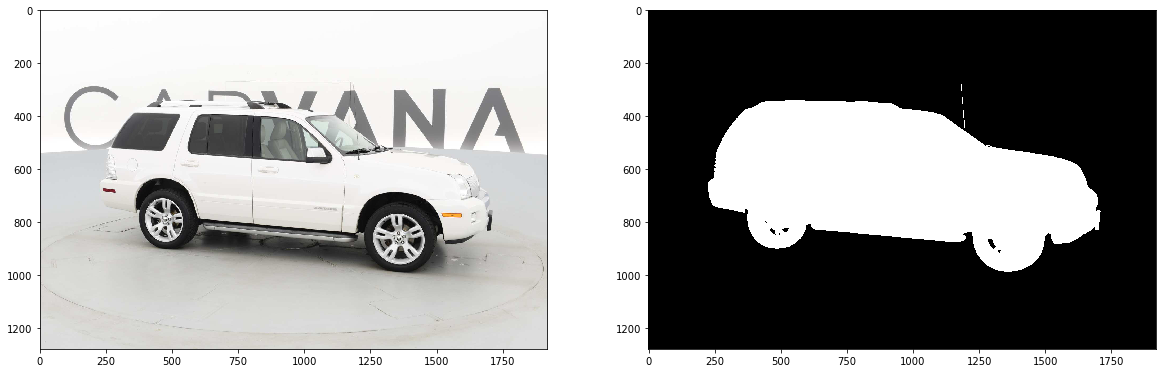

In [5]:
# car_p = ((car_pictures[0]).split("."))[0]

import matplotlib.pyplot as plt
import matplotlib.image as image
%matplotlib inline

# f=plt.imread('../train/61060ada97c9_01.jpg')
car_pic = image.imread(train_random_choice_path)
mask_pic = image.imread(train_random_mask_path)

f, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()
ax[0].imshow(car_pic)
ax[1].imshow(mask_pic)

In [6]:
car_pic.shape

(1280, 1918, 3)

In [7]:
mask_pic.shape[0]

1280

In [8]:
import openslide
from keras.utils.np_utils import to_categorical
import threading

# class threadsafe_iter:
#     def __init__(self, it):
#         self.it = it
#         self.lock = threading.Lock()
    
#     def __iter__(self):
#         return self
    
#     def __next__(self):
#         with self.lock:
#             return self.it.__next__()

# def threadsafe_generator(f):
#     def g(*args, **kw):
#         return threadsafe_iter(f(*args, **kw))
#     return g

# @threadsafe_generator
def data_generator(data_set, batch_size=32, widths=128, heights=128):

    images = []
    masks = []
    for i in range(batch_size):
        random_choice = np.random.choice(data_set)    # 从给定的数据集中随机选取一张
        random_choice_path = join(base_path, "train/" + random_choice)    # 获得该随机图片的路径
        random_mask_path = join(base_path, "train_masks/" + (random_choice.split("."))[0] + "_mask.gif")    # 获得该随机图片对应的mask

        car_pic = image.imread(random_choice_path)    # 读取该随机图片
        mask_pic = image.imread(random_mask_path)    # 读取该随机图片对应的mask

        random_num = np.random.random(1)
#         print("产生的随机数是:%s"%random_num)
        if random_num > 0.5:    # 必须取到一张包含汽车至少一个像素的图片
            random_x = np.random.randint(0, car_pic.shape[1] - widths)
            random_y = np.random.randint(0, car_pic.shape[0] - heights)
            slide = openslide.open_slide(train_random_mask_path)
            slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
            slide_arr = np.array(slide1.convert("L"))
            slide_y, slide_x = np.nonzero(slide_arr)
            while len(slide_x) == 0:
                random_x = np.random.randint(0, car_pic.shape[1] - widths)
                random_y = np.random.randint(0, car_pic.shape[0] - heights)
                slide = openslide.open_slide(train_random_mask_path)
                slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
                slide_arr = np.array(slide1.convert("L"))
                slide_y, slide_x = np.nonzero(slide_arr)
            masks.append((slide_arr>0).astype(int))
            img = (openslide.open_slide(train_random_choice_path)).read_region((random_x,random_y),0,(widths,heights))
            images.append(np.array(img.convert("RGB")))
        else:
            random_x = np.random.randint(0, car_pic.shape[1] - widths)
            random_y = np.random.randint(0, car_pic.shape[0] - heights)
            slide = openslide.open_slide(train_random_mask_path)
            slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
            slide_arr = np.array(slide1.convert("L"))
            slide_y, slide_x = np.nonzero(slide_arr)
            while len(slide_x) != 0:
                random_x = np.random.randint(0, car_pic.shape[1] - widths)
                random_y = np.random.randint(0, car_pic.shape[0] - heights)
                slide = openslide.open_slide(train_random_mask_path)
                slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
                slide_arr = np.array(slide1.convert("L"))
                slide_y, slide_x = np.nonzero(slide_arr)
            masks.append(np.zeros((widths,heights)))
            img = (openslide.open_slide(train_random_choice_path)).read_region((random_x,random_y),0,(widths,heights))
            images.append(np.array(img.convert("RGB")))

    X_train = np.array(images)
    y_train = np.array(masks)
#     print(y_train.shape[0],y_train.shape[1])
    y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], widths, heights, 2)
    yield X_train,y_train

Using TensorFlow backend.


In [9]:
%time exampl_X, example_y = next(data_generator(train_set,batch_size=32,widths=128,heights=128))

CPU times: user 3.86 s, sys: 124 ms, total: 3.98 s
Wall time: 4.69 s


In [10]:
exampl_X.shape, example_y.shape

((32, 128, 128, 3), (32, 128, 128, 2))

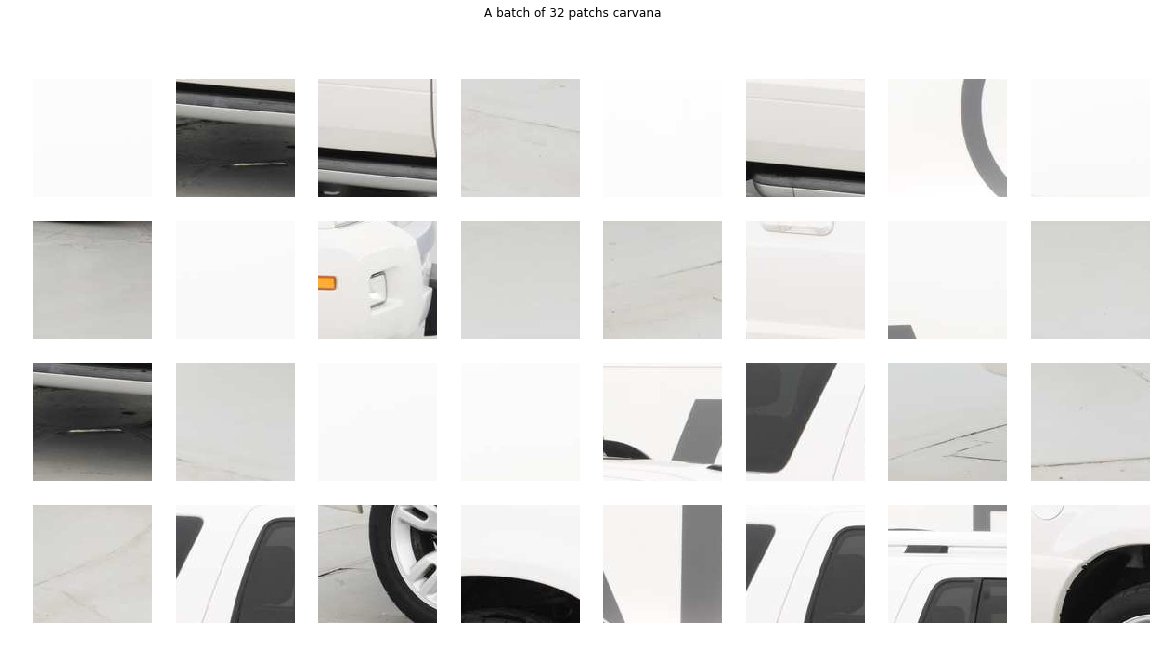

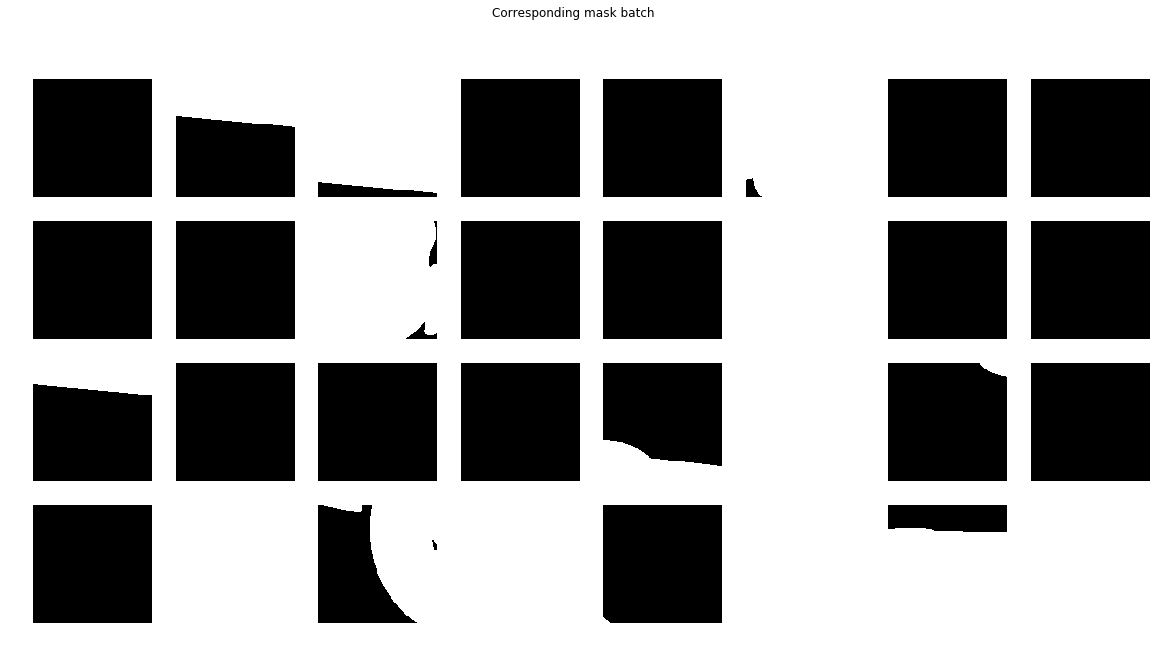

In [11]:
f, axes = plt.subplots(4, 8, figsize=(20,10));
ax = axes.flatten();
for i in range(exampl_X.shape[0]):
    _ = ax[i].imshow(exampl_X[i]);
    _ = ax[i].axis('off');
f.suptitle('A batch of 32 patchs carvana');

f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten();
for i in range(example_y.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Corresponding mask batch');

搭建深度学习网络模型

In [12]:
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(128,128,3)))
model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(300, (3, 3), activation='relu', padding='same'))

model.add(Dropout(0.1))
model.add(Convolution2D(2, (1, 1)))
model.add(Conv2DTranspose(2, (31, 31), strides=(16,16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 100)       2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 200)       180200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 200)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 300)         540300    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 300)         810300    
__________

In [16]:
from datetime import datetime
from keras.callbacks import CSVLogger

epochs = 20

start_time = datetime.now()
csvlogger = CSVLogger('train_20_100.log', append=True)

model.fit_generator(data_generator(train_set),
                   steps_per_epoch=100,
                   epochs=epochs,
                   validation_data=data_generator(valid_set),
                   validation_steps=20,
                   verbose=1,
                   callbacks=[csvlogger])
model.save('model_20_100.h5')
end_time = datetime.now()
print('Model Training Time:%.1f minutes'%((end_time-start_time).seconds / 60,))

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=20, callbacks=[<keras.ca..., max_queue_size=1, steps_per_epoch=100, verbose=1, validation_data=<generator..., validation_steps=20)`
  app.launch_new_instance()


Epoch 1/20


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/src/keras/utils/data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
StopIteration



  1/100 [..............................] - ETA: 694s - loss: 0.6905 - acc: 0.5457

StopIteration: 